# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<span style="color: blue">Remove all blue text before submitting</span>

<a id="top"></a>
## Contents
* <a href="#Create">Create Models</a>
    * <a href="#Prep">Data Preparation</a>
    * <a href="#LR">Logistic Regression Model</a>
    * <a href="#SVM">Support Vector Machine Model</a>
* <a href="#Model">Model Advantages</a>
* <a href="#Interpret">Interpret Feature Importance</a>
* <a href="#Support">Interpret Support Vectors</a>

In [67]:
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics as mt

### Supporting Functions

In [68]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [69]:
verboseStatus = False

In [70]:
# Brett's directory
# Desktop
# %cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
#%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory.
%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
#%cd "C:\Users\Nicole Wittlin\Documents\7331DataMining\EducationDataNC\2017\Raw Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

print('********* Initial Values Before Cleaning *******************')
dfPublicHS.info(verbose = verboseStatus)

/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets
********* Initial Values Before Cleaning *******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


<a id="Create"></a>
<a href="#top">Back to Top</a>
## Create Models (50 points)

<a id="Prep"></a>
### Data Preparation

There are 403 columns in our dataset. We dropped any columns that have zero variance and only dropped one column. We also wanted to remove highly correlated variables to reduce multi-collinearity. For a Pearson R threshold of 0.8, we removed any variables where the `r` value was greater than `0.8`. As a result, we dropped 124 highly correlated variables in the code blocks below. We used the dropped columns dataset to build our logistic regression model and for our initial SVM model to compare the performance between the two models. We will talk about the model performance later on in our notebook.

In [71]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [72]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [73]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print(to_drop)
print("Columns dropped: {}".format(len(to_drop)))

['lea_state_perpupil_num', '4-Year Cohort Graduation Rate Score', 'ACTMath_ACTBenchmark_All', 'ACTScience_ACTBenchmark_All', 'ACTWorkKeys_SilverPlus_All', 'ACTWriting_ACTBenchmark_All', 'EOCSubjects_CACR_All', 'ACTCompositeScore_UNCMin_Female', 'ACTEnglish_ACTBenchmark_Female', 'ACTMath_ACTBenchmark_Female', 'ACTReading_ACTBenchmark_Female', 'ACTScience_ACTBenchmark_Female', 'ACTWorkKeys_SilverPlus_Female', 'EOCBiology_CACR_Female', 'EOCEnglish2_CACR_Female', 'GraduationRate_5yr_Female', 'ACTCompositeScore_UNCMin_Male', 'ACTMath_ACTBenchmark_Male', 'ACTScience_ACTBenchmark_Male', 'ACTWorkKeys_SilverPlus_Male', 'ACTWriting_ACTBenchmark_Male', 'EOCBiology_CACR_Male', 'EOCEnglish2_CACR_Male', 'EOCMathI_CACR_Male', 'ACTMath_ACTBenchmark_AmericanIndian', 'ACTWorkKeys_SilverPlus_AmericanIndian', 'ACTWriting_ACTBenchmark_AmericanIndian', 'EOCBiology_CACR_AmericanIndian', 'EOCEnglish2_CACR_AmericanIndian', 'EOCMathI_CACR_AmericanIndian', 'GraduationRate_4yr_AmericanIndian', 'ACTWriting_ACTBenc

We performed some data preparation before running our logistic regression and SVM models. Since our target variable is a continuous variable, we needed to split the target variable evenly into a binary response so our data was split at the median. We created a new variable called `schoolPctTarget` and assigned a value of `1` to schools with students enrolled in a postsecondary institution greater or equal to the median value (52.18%) and `0` to schools with less than the median value of 52.18%.

It is important to create a split dataset so we do not train a model that is better at classifying one side than the other therefore, we want our model to be trained on both binary values. 

In [42]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)

print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

235 of 470: 50.0%


In [43]:
y = dfDropped['schoolPctTarget']

# ADD STUFF ABOUT 80/20 SPLIT

In [44]:
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfDropped.filter(regex = r'sch_pct')

dfDropped.drop(dropCols, axis = 1, inplace = True)

In [45]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [46]:
maxCols = dfDropped.shape[1]
X = dfDropped.iloc[:,0:maxCols-2]

In [47]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

In [48]:
# This cell needs to be moved but for now I'm going to put it here
xTrainLR = xTrain
xTestLR = xTest
yTrainLR = yTrain
yTestLR = yTest

<a id = "LR"></a>
## Logistic Regression?

In [49]:
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

#iter_num=0
# the indices are the rows used for training and testing in each iteration
#for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
#    X_train = X[train_indices]
#    y_train = y[train_indices]
    
#    X_test = X[test_indices]
#    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
lr_clf.fit(X, y)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

scores = cross_val_score(lr_clf, X, y, cv=cv_object)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

accuracy 0.6276595744680851
confusion matrix
 [[30 19]
 [16 29]]
Accuracy: 0.65 (+/- 0.07)


In [50]:
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(xTrain) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(xTrain) # apply to training
X_test_scaled = scl_obj.transform(xTest) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,yTrain)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,X.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7127659574468085
[[34 15]
 [12 33]]
TwoOrMoreFemalePct has weight of -0.351153295921621
pct_eds has weight of -0.2641389216379215
PacificIslandFemalePct has weight of -0.26154641664378525
GraduationRate_4yr_SWD has weight of -0.22653495571580592
lea_advance_dgr_pct has weight of -0.22607529690702902
stud_internet_comp_num has weight of -0.19737579450979073
Accomplished_TCHR_Standard 5_Pct has weight of -0.19712519833006897
cte_courses has weight of -0.18277056929129568
calendar_type_txt_Regular School, Year-Round Calendar has weight of -0.17215728627334437
grade_range_cd_PK-12 has weight of -0.1690745395560426
MathGr10_pTarget_PctMet has weight of -0.16838655129375932
GraduationRate_5yr_EDS has weight of -0.16535591104541253
GraduationRate_5yr_LEP has weight of -0.16167696104106302
grades_1_to_1_access_6:07:08 has weight of -0.1608282305934419
GraduationRate_4yr_LEP has weight of -0.1558720826249102
GraduationRate_4yr_Hispanic has weight of -0.1552652700105611
HispanicMaleP

still 401 explanatory variables at the moment, need to figure out how to knock a lot out. L1 (lasso regression) gave about 2% increase in accuracy compared to L2 (ridge regression). but that could just be due to randomness if we re-ran them a few more times. also need to figure out GridSearchCV for the costs on this one.

In [51]:
len(zip_vars)

273

<a id="SVM"></a>
## Support Vector Machines

### Column preparation

At this point, the dataset contains 'future' information that the model should not be aware of. Including these variables would create a leak since the historical data that was collected gives information on the target variable.  We need to drop these columns before we build the model. In addition, some of the column names don't start with alpha characters which cause code later in the notebook to miss these columns and not graph the most significant support vectors correctly. 

In [52]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings

# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct')

# Drop columns
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

### Linear Regression Features
For comparison against the two models, we'll build a model with the attributes used for the linear regression model

In [53]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [54]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrainLR, yTrainLR)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 21:33:37.506597
CPU times: user 3.42 s, sys: 25.4 ms, total: 3.44 s
Wall time: 2.71 s
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.732 (+/-0.120) for {'C': 1}
0.716 (+/-0.160) for {'C': 10}
0.713 (+/-0.143) for {'C': 100}
0.713 (+/-0.143) for {'C': 1000}



In [55]:
# Set model to best values found
cls = SVC(C = bestValues['C'], kernel = 'linear')

# Train
cls.fit(xTrainLR, yTrainLR)

# Predict test values
yhat = cls.predict(xTestLR)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[31 18]
 [14 31]]
             precision    recall  f1-score   support

          0       0.69      0.63      0.66        49
          1       0.63      0.69      0.66        45

avg / total       0.66      0.66      0.66        94



### Feature Selection
Using the ANOVA F-value to determine which columns have the greatest proportion of variance, we select the top 10% to be used in our model. The F-value tells us which column(s) help to explain the greatest amount of variance in the target variable. The columns with the highest proportion allows the model to solve for the greatest separation on attributes for classification.

In [56]:
# Subset the data to exclude the target variable
maxCols = dfPublicHS.shape[1]
X = dfPublicHS.iloc[:,0:maxCols-2]

# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

### Data split
Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [57]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

### Parameter Tuning
Here we create a range of values to test the model against to determine which parameters provide the best result.

In [58]:
# Set parameter turning values and create a grid of models to run
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=[1,10,100,1000])

gridRBF = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [59]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
%time gridRBF.fit(xTrain, yTrain)

bestValues = gridRBF.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridRBF scores on development set:")
print()
means = gridRBF.cv_results_['mean_test_score']
stds = gridRBF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridRBF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 21:33:40.290915
CPU times: user 6.37 s, sys: 12 ms, total: 6.39 s
Wall time: 6.4 s
Best parameters set found on development set:

{'C': 1000, 'gamma': 0.0001}

gridRBF scores on development set:

0.503 (+/-0.011) for {'C': 1, 'gamma': 1e-09}
0.503 (+/-0.011) for {'C': 1, 'gamma': 1e-08}
0.503 (+/-0.011) for {'C': 1, 'gamma': 1e-07}
0.503 (+/-0.011) for {'C': 1, 'gamma': 1e-06}
0.503 (+/-0.011) for {'C': 1, 'gamma': 1e-05}
0.697 (+/-0.140) for {'C': 1, 'gamma': 0.0001}
0.700 (+/-0.126) for {'C': 1, 'gamma': 0.001}
0.689 (+/-0.130) for {'C': 1, 'gamma': 0.01}
0.684 (+/-0.139) for {'C': 1, 'gamma': 0.1}
0.588 (+/-0.151) for {'C': 1, 'gamma': 1.0}
0.503 (+/-0.011) for {'C': 1, 'gamma': 10.0}
0.503 (+/-0.011) for {'C': 1, 'gamma': 100.0}
0.503 (+/-0.011) for {'C': 1, 'gamma': 1000.0}
0.503 (+/-0.011) for {'C': 10, 'gamma': 1e-09}
0.503 (+/-0.011) for {'C': 10, 'gamma': 1e-08}
0.503 (+/-0.011) for {'C': 10, 'gamma': 1e-07}
0.503 (+/-0.011) for {'C': 10, 'gamma': 1e-06}
0

### Test Model
Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [60]:
# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[31 15]
 [16 32]]
             precision    recall  f1-score   support

          0       0.66      0.67      0.67        46
          1       0.68      0.67      0.67        48

avg / total       0.67      0.67      0.67        94



### ROC Curve
Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

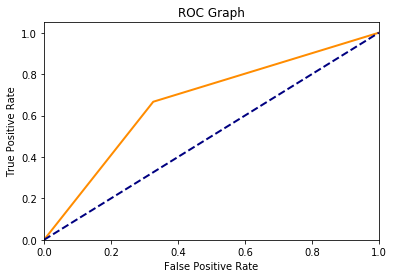

In [61]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

### Most influential Support Vectors
The graph below helps us determine which attributes have the most impact on the boundary between support vectors. This gives us some indication of what attributes might help increase the number of students enrolled in postsecondary education.

In [62]:
# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

AttributeError: coef_ is only available when using a linear kernel

### Parameter Tuning
Here we create a range of values to test the model against to determine which parameters provide the best result.

In [ ]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [ ]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrain, yTrain)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

### Test Model
Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [ ]:
cls = SVC(C = bestValues['C'], kernel = 'linear')

In [ ]:
# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

### ROC Curve
Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

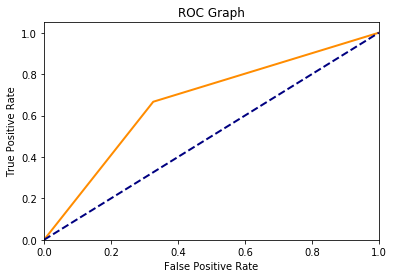

In [63]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

### Most influential Support Vectors
The graph below helps us determine which attributes have the most impact on the boundary between support vectors. This gives us some indication of what attributes might help increase the number of students enrolled in postsecondary education.

In [65]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

AttributeError: coef_ is only available when using a linear kernel

In [ ]:
# Cool Plot
# http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py

<a href="#top">Back to Top</a>
<a id="Model"></a>
## Model Advantages (10 points)
<span style="color: blue">Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</span>

<a href="#top">Back to Top</a>
<a id="Interpret"></a>
## Interpret Feature Importance (30 points)

<span style="color: blue">Use the weights from logistic regression to interpret the importance of different features for the classification task. <b>Explain your interpretation in detail.</b>Why do you think some variables are more important?

<a href="#top">Back to Top</a>
<a id="Support"></a>
## Interpret Support Vectors (10 points)
<span style="color:blue">Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.